# Shopping QnA

- Author: [Mark](https://github.com/obov)
- Design: []()
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/08-MultiModalEmbeddings.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/08-Embeeding/08-MultiModalEmbeddings.ipynb)

## Overview

### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [Data Augmentation](#data-augmentation)
- [Storing embedded values in VectorDB](#storing-embedded-values-in-vectordb)
- [Vector Search](#vector-search)
- [Multimodal RAG Chatbot](#multimodal-rag-chatbot)

### References

- [Bedrock Multimodal RAG Chatbot](https://aws.amazon.com/ko/blogs/tech/bedrock-multimodal-rag-chatbot/)
- [Public Multimodal RAG Chatbot](https://github.com/hi-space/public-multimodal-rag-chatbot/tree/main)
- [Kream Product BLIP Captions](https://huggingface.co/datasets/hahminlew/kream-product-blip-captions)
- [LangChain Multimodal Inputs](https://python.langchain.com/docs/how_to/multimodal_inputs/)

---


## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**

- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials.
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.


In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "datasets",
        "langchain",
        "langchain_core",
        "langchain_openai",
    ],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "Your API KEY",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Caching",
    }
)

Environment variables have been set successfully.


In [4]:
# Alternatively, one can set environmental variables with load_dotenv
from dotenv import load_dotenv


load_dotenv(override=True)

True

## Data Augmentation

To generate a dataset suitable for a virtual shopping mall’s product database using the KREAM Product BLIP Captions dataset, we need to perform data augmentation.


In [5]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("hahminlew/kream-product-blip-captions")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 14904
    })
})


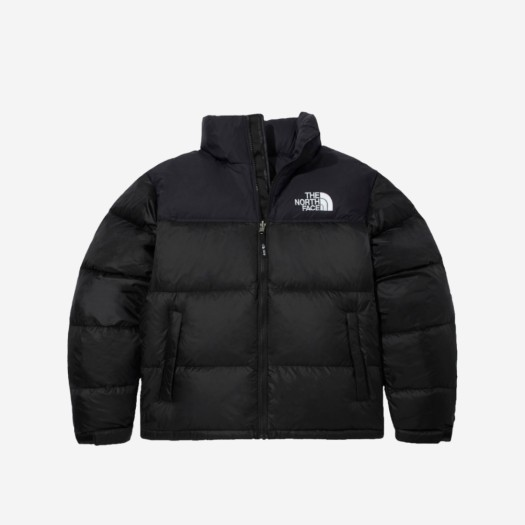

outer, The North Face 1996 Eco Nuptse Jacket Black, a photography of the north face black down jacket


In [6]:
from IPython.display import display

display(dataset["train"][0]["image"])
print(dataset["train"][0]["text"])

Dataset({
    features: ['image', 'text'],
    num_rows: 10
})
10


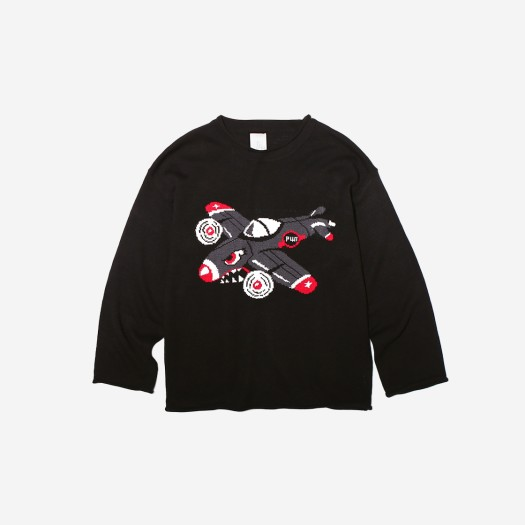

top,  P40 Knit Black, a photography of a black long sleeved shirt with a motorcycle motif


In [7]:
# Sample Size
SAMPLE_SIZE = 10

# Randomly sampling
sampled_dataset = dataset["train"].shuffle(seed=42).select(range(SAMPLE_SIZE))

print(sampled_dataset)
print(len(sampled_dataset))
display(sampled_dataset[0]["image"])
print(sampled_dataset[0]["text"])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=525x525 at 0x177658F10>, 'text': 'top,  P40 Knit Black, a photography of a black long sleeved shirt with a motorcycle motif'}


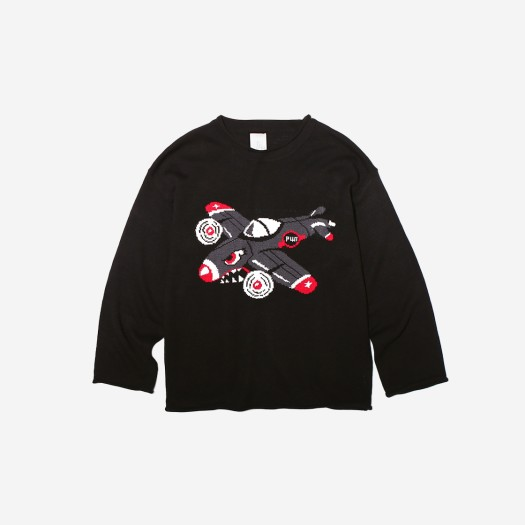

'PNG'

In [8]:
def sample_item_process(item):
    splited = item["text"].split(",")
    return {
        "image": item["image"],
        "type": splited[0],
        "name": splited[1],
        "summary": splited[2],
    }


processed_dataset = [sample_item_process(item) for item in sampled_dataset]
print(sampled_dataset[0])
display(sampled_dataset[0]["image"])
display(sampled_dataset[0]["image"].format)

In [9]:
# Json Data Augmentation

import base64
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from io import BytesIO
import json
from langchain_core.output_parsers import BaseOutputParser


# Create model
llm_multimodal = ChatOpenAI(model_name="gpt-4o")


# PIL Image to Base64
def pil_image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def process_item_to_prompt(item):
    image_data = pil_image_to_base64(item["image"])
    type = item["type"]
    name = item["name"]

    message = HumanMessage(
        content=[
            {
                "type": "text",
                "text": "Look at the image and properties of this product and describe it\n"
                "Format the response as a JSON object with four keys: 'summary', 'image_summary' and 'tags'.\n"
                "- 'summary': Summary of product form based on appearance in a sentence\n"
                "- 'image_summary': Describe this image of product based on its type, color, material, pattern, and features.\n"
                "- 'tags':  An array of strings representing key features or properties that can represent color, pattern, material, type of the product.\n",
            },
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
            },
            {
                "type": "text",
                "text": f"The product is a type of {type} and name is {name}.",
            },
        ],
    )

    return message


class JsonOutputParser(BaseOutputParser[dict]):
    def parse(self, text: str) -> dict:
        text = text[7:-3]
        return json.loads(text)


response = (llm_multimodal | JsonOutputParser()).invoke(
    [process_item_to_prompt(processed_dataset[0])]
)
print(response)


# Use batch to process multiple messages
response = (llm_multimodal | JsonOutputParser()).batch(
    [
        [process_item_to_prompt(processed_dataset[1])],
        [process_item_to_prompt(processed_dataset[2])],
    ]
)
print(response[0])
print(response[1])

{'summary': 'A knitted black sweater featuring an airplane graphic design.', 'image_summary': 'This is a black knit sweater with a graphic pattern of an airplane in shades of gray, red, and white. The design is prominently displayed on the front, giving it a playful and bold appearance.', 'tags': ['black', 'knit', 'sweater', 'airplane', 'graphic', 'red', 'white']}
{'summary': 'A stylish black quilted down gilet with a high collar and button closures.', 'image_summary': 'This is a black, sleeveless, quilted down gilet with a high collar. It features button closures down the front, two chest pockets with flaps, and a subtle logo on one of the pockets.', 'tags': ['black', 'quilted', 'down', 'gilet', 'sleeveless', 'high collar', 'button closures', 'chest pockets']}
{'summary': 'These are navy cargo shorts with a sporty design and durable features.', 'image_summary': 'The product is a pair of navy blue cargo shorts made from Gore-Tex material, featuring a belt, multiple pockets, and blue zi

In [10]:
# Description Data Augmentation

from langchain_core.output_parsers import StrOutputParser

json_augmentation_data = {**processed_dataset[0], **response[0]}


def json_augmentation_item_to_prompt(item):
    image_data = pil_image_to_base64(item["image"])

    message = HumanMessage(
        content=[
            {
                "type": "text",
                "text": "look at the image of the product and properties and write a detailed and narrative product description\n"
                "Keep a lively tone and use a hook to make users want to buy the product.\n"
                "Do not include tags or other descriptions.\n"
                "\n"
                "Here are the properties of the product\n"
                f"{json.dumps({k: v for k, v in item.items() if k != 'image'}, indent=4)}\n",
            },
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
            },
        ],
    )

    return message


response = (llm_multimodal | StrOutputParser()).invoke(
    [json_augmentation_item_to_prompt(json_augmentation_data)]
)
print(response)

Introducing the P40 Knit Black, an irresistible blend of style and comfort that will elevate your wardrobe to new heights! This exquisite black knit top captures attention with its bold, playful airplane design, intricately woven to stand out against the rich, dark fabric. 

Imagine slipping into this cozy masterpiece as you conquer your day with effortless flair. The P40 Knit Black is not just a top; it's a statement. Its soft, breathable fabric promises comfort, while the dynamic design adds a touch of whimsy to your look. Whether you're dressing it up for a night out or keeping it casual for a day of adventure, this top is your perfect co-pilot. 

Don't miss out on the chance to own a piece that combines classic style with a modern twist. Add the P40 Knit Black to your collection today and soar through your day in ultimate style!


In [11]:
# Combine Data Augmentation Chains

from langchain_core.runnables import (
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from pprint import pprint

augmentation_multimodal_chain = (
    RunnableParallel(  # JSON Augmentation
        {
            "processed": RunnablePassthrough(),
            "json_augmented": RunnableLambda(lambda x: [process_item_to_prompt(x)])
            | llm_multimodal
            | JsonOutputParser(),
        }
    )
    | RunnableLambda(  # Merge JSON Augmentation and Processed Data
        lambda x: {
            **x["processed"],
            **x["json_augmented"],
        }
    )
    | RunnableParallel(  # Description Augmentation
        {
            "process_and_json_augmented": lambda x: x,
            "description_augmented": RunnableLambda(
                lambda x: [json_augmentation_item_to_prompt(x)]
            )
            | llm_multimodal
            | StrOutputParser(),
        }
    )
    | RunnableLambda(  # Merge Description Augmentation and Processed Data
        lambda x: {
            **x["process_and_json_augmented"],
            "description": x["description_augmented"],
        }
    )
)

augmentation_dataset = augmentation_multimodal_chain.batch(processed_dataset)

print(len(augmentation_dataset))
pprint(augmentation_dataset[0])

10
{'description': 'Introducing the P40 Knit Black top—a perfect blend of bold '
                'style and comfort that elevates your wardrobe to new heights! '
                'This black knit masterpiece features a vibrant airplane '
                'graphic soaring across the front in striking red, white, and '
                "gray. It's not just a top; it's a statement.\n"
                '\n'
                'Imagine slipping into the soft, luxurious knit fabric that '
                'feels like a gentle embrace, while the playful airplane '
                'design adds a dash of daring flair to your look. Whether '
                "you're stepping out for a casual day with friends or taking "
                'off on a new adventure, this top ensures you do it with '
                'unmatched style.\n'
                '\n'
                'The P40 Knit Black isn’t just about looks—it’s about feeling '
                'fabulous. The bold graphic captures attention and sparks '


## Storing embedded values in VectorDB


## Vector Search


## Multimodal RAG Chatbot
